# Imports, reading data

In [54]:
#from pyspark.sql import SparkSession
import pandas as pd
import random
import numpy as np
import csv
import json
#import torch
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
#import random
#import pandas as pd
from sklearn.metrics import accuracy_score
#from typing import List
random_seed = 25 # so that we can have consistent user assignment across teammates
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('ReadCSV').getOrCreate()

# Read all CSV files in a directory
parquet_directory_path = '../data/development/'
data = spark.read.parquet(parquet_directory_path, header=True, inferSchema=True)

# IMPORTANT: Map itemid to integers first

In [72]:
# Initialize Spark session
#spark = SparkSession.builder.appName('ReadCSV').getOrCreate()

# Read all CSV files in a directory
#parquet_directory_path = 'filtered_data/'
#data = spark.read.parquet(parquet_directory_path, header=True, inferSchema=True)


## IMPORTANT: embedding layers require the categorical variable item id
## to be mapped to contiguous integers 0 to number of itemid - 1. 

# 1: Create a mapping for item_id to integers
unique_item_ids = df['item_id'].unique()
item_id_mapping = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}

# 2: Apply the mapping to the DataFrame
df['item_id'] = df['item_id'].map(item_id_mapping)

# 3: Convert other columns to integers (jus to make sure we dont have any issue on dtypes!) 
df = df.astype('int')




# Experiment: Test manual implementation of the nested CV

In [ ]:
def split_df_into_folds(df: pd.DataFrame, n_fold: int) -> List[pd.DataFrame]:
    # Get unique user IDs
    unique_user_ids = df['user_id'].unique().tolist()
    # Shuffle user IDs to ensure random distribution
    random.shuffle(unique_user_ids)

    # Split user IDs into n_fold chunks
    user_id_chunks = [unique_user_ids[i::n_fold] for i in range(n_fold)]

    # Create the DataFrames for each fold
    folds = []
    for chunk in user_id_chunks:
        # Select rows where user_id is in the current chunk
        fold_df = df[df['user_id'].isin(chunk)]
        folds.append(fold_df)

    return folds

def nested_cross_validation(df: pd.DataFrame, n_outer: int, n_inner: int):
    # Step 1: Outer loop - Split the data into n_outer folds based on user_id
    outer_folds = split_df_into_folds(df, n_outer)

    for outer_idx, outer_fold in enumerate(outer_folds):
        # Split outer_fold into training and validation sets
        outer_train_data = df[~df['user_id'].isin(outer_fold['user_id'])]
        outer_val_data = outer_fold

        # Visualize the first user_id in the outer fold
        first_outer_user_id = outer_fold['user_id'].iloc[0]
        print(f"Outer Fold {outer_idx + 1}/{n_outer} - First user_id: {first_outer_user_id}")

        # Step 2: Inner loop - Split outer_train_data into n_inner folds for hyperparameter tuning
        inner_folds = split_df_into_folds(outer_train_data, n_inner)

        for inner_idx, inner_fold in enumerate(inner_folds):
            # Visualize the first user_id in the inner fold
            first_inner_user_id = inner_fold['user_id'].iloc[0]
            print(f"  Inner Fold {inner_idx + 1}/{n_inner} - First user_id: {first_inner_user_id}")

In [4]:
splitted_df_into_folds = split_df_into_folds(df, 20)

In [5]:
splitted_df_into_folds[1].user_id.unique().shape

(22,)

# NAM Implementation + execution (1408 mins ~ 24 hours for the 20 fold NCV)

In [55]:
import torch; import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import pandas as pd
from sklearn.metrics import accuracy_score
from typing import List
random_seed = 25
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)


# device configuration (all cpu or gpu. Must be conssitent)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ExU(nn.Module):
    ### activation function proposed in NeurIPS paper to model highly jumpy relationshisp
    
    def __init__(self):
        super(ExU, self).__init__()

    def forward(self, x):
        # squishes the input to a bounded interval avoid overflow in exp
        # (else validation error will blow up and will show NaN or something)


        x = torch.clamp(x, min=-20, max=20)  # squish to a reasonable range
        positive_part = torch.exp(x) - 1
        negative_part = -torch.exp(-x) + 1
        return torch.where(x >= 0, positive_part, negative_part)



# NAM Feature-specific neural network
FEATURENN_DEBUG = 0
class FeatureNN(nn.Module):

    ### feature specific neural network f_k(x_k) in the NAM architecture.
    ### specifically, for the 4 binary features represtning item type and the timestep features

    def __init__(self, input_shape, num_units, hidden_sizes, dropout, activation='relu'):

        # just realized that python has docstring. Oh well. So much for putting ### s
        """ 
        initializes the feature-specific network.

        argss: 
            input_shape (int): Shape of the input feature (typically 1 for scalar features).
            num_units (int): Number of units in the input layer.
            hidden_sizes (list): List of hidden layer sizes.
            dropout (float): Dropout rate for regularization.
            activation (str): Activation function ('relu' or 'exu').

        """
        super(FeatureNN, self).__init__()
        layers=[]

        # Activation function choice

        activation_function = nn.ReLU() if activation == 'relu' else ExU()

        # Input layer
        layers.append(nn.Linear(input_shape, num_units))
        layers.append(activation_function)

        # Hidden layers
        # keep track of current input size so that matrix mults are well defined. 
        curr_input_neurons = num_units 
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(curr_input_neurons, hidden_size))  # Correctly using the previous output size
            layers.append(activation_function)
            layers.append(nn.Dropout(dropout))
            curr_input_neurons = hidden_size  # Update curr.input size to next hidden layer to match the output size of this layer

        # Final layer to output f_k(x_k) as a scalar
        layers.append(nn.Linear(curr_input_neurons, 1))  # Outputs a scalar for f_k(x_k)

        # now our network is basically a sequence of fc layers. 
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x) # just passing thru a sequence of fully connected layers. 
        if FEATURENN_DEBUG: print(f"Output of FeatureNN (f_k(x_k)): {x.shape}, should be [batchsize x 1]")  # Should be [batch_size, 1] for each feature
        return x


class EmbeddingNN(nn.Module):
    
    ### a dedicated neural network for the embedding vector encoding the itemids,
    ### essentially a scalar valued function taking embedding vector as imput 
    ### (itemid is categorical)

    def __init__(self, embedding_size, hidden_sizes, dropout, activation='relu'):

        super(EmbeddingNN, self).__init__()
        
        layers = []
        
        # act func choice
        activation_function = nn.ReLU() if activation == 'relu' else ExU()

        # 1st layer: R^embedding size --> R^hidden_sizes[0]
        layers.append(nn.Linear(embedding_size, hidden_sizes[0]))
        layers.append(activation_function)

        # next layers: R^hidden_sizes[i] --> R^hidden_sizes[i+1]
        current_input_size = hidden_sizes[0]
        for hidden_size in hidden_sizes[1:]:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(activation_function)
            layers.append(nn.Dropout(dropout))
            current_input_size=hidden_size # IMPORTANT!

        # Output a scalar f_k(x_k) as per definition of the NAM
        layers.append(nn.Linear(current_input_size, 1))

        # just the definition of the fully connected layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

NAM_FORWARD_DEBUG = 0

class NAMWithEmbeddings(nn.Module):
    def __init__(self, num_inputs, num_units, hidden_sizes, dropout, feature_dropout,
    embedding_size, num_item_ids, num_classes, activation='relu'):

        ### The complete class definition for our NAM implementation (with embeddings).
        ### since we are doing multicategorical logistic regression (multiple ouputs),
        ### the outputs f_1(x_1) , ... , f_6(x_6) will be treated as inputs to 
        ### another fully connected layer to output the logits

        super(NAMWithEmbeddings, self).__init__()
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.hidden_sizes = hidden_sizes
        self.dropout = dropout
        self.feature_dropout = feature_dropout
        self.num_classes = num_classes

        # Embedding layer for item_id
        self.item_id_embedding = nn.Embedding(num_item_ids, embedding_size)

        # Feature-specific neural networks
        self.feature_nns = nn.ModuleList([
            FeatureNN(1, num_units[i], hidden_sizes, dropout, activation) for i in range(num_inputs)
        ])

        # Embedding-specific network
        self.embedding_nn = EmbeddingNN(embedding_size, hidden_sizes, dropout, activation)

        # Dropout layer for the concatenated features (regulaisatinion)
        self.dropout_layer = nn.Dropout(p=self.feature_dropout)

        # Fully connected layer to produce logits
        input_size_to_fc = self.num_inputs + 1  # +1 for the scalar output from the embedding-specific network
        self.fc = nn.Linear(input_size_to_fc, num_classes)

    def forward(self, inputs, item_ids):

        ## nn.Linear can be very picky with data types, for some reason...
        inputs = inputs.to(torch.float32)
        item_ids = item_ids.to(torch.long)

        # 1)) get embedding
        item_id_embedded = self.item_id_embedding(item_ids)
        if NAM_FORWARD_DEBUG: print(f"item_id_embedded shape: {item_id_embedded.shape}")

        # 2)) process embedding through its own network
        embedding_output = self.embedding_nn(item_id_embedded) # do a forward pass in the embedding nn. 
        if NAM_FORWARD_DEBUG: print(f"embedding_output shape (scalar): {embedding_output.shape}")

        # 3)) process features through their networks
        feature_outputs = []
        for i in range(self.num_inputs):
            feature_input = inputs[:, i:i+1]
            feature_output = self.feature_nns[i](feature_input)
            feature_outputs.append(feature_output)

        # 4) Concatenate all outputs (feature scalars + embedding scalar)
        all_outputs = torch.cat(feature_outputs+[embedding_output], dim=-1)

        # 5)) Pass through the fully connected layer to get logits

        logits = self.fc(all_outputs)
        if NAM_FORWARD_DEBUG: print(f"logits shape: {logits.shape}")

        return logits



class CustomDataset(Dataset):
    """
    custom PyTorch Dataset class to handle loading the dataset into DataLoader,
    so that we can implement the (mini) batch gradient desent.
    """
    def __init__(self, df):
        self.df = df
        self.item_ids = df['item_id'].values  # This should ideally be a single item ID per sample
        self.ratings_discretized = df['ratings_discretized'].values  
        self.other_features = df[['istrack', 'isalbum', 'isartist', 'isgenre', 'timestep']].values  # The 5 features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item_id = self.item_ids[idx]
        label = self.ratings_discretized[idx]

        # Ensure other features are returned as a 1D tensor of shape [num_features]
        other_features = torch.tensor(self.other_features[idx], dtype=torch.float)

        return torch.tensor(item_id, dtype=torch.long), other_features, torch.tensor(label, dtype=torch.long)

## grid of hyperparameters to tune. Just stick to a small grid for now, since current grid alrd has 32 total hyperparam combinations now. 

# would have been wise to employ L2 regularization nof the norms since ExU can bloe up outputs on hidden neurons.. 

hyperparam_grid = {
    'num_units': [[32, 32, 32, 32, 32, 32],
                    [64, 64, 64, 64, 64, 64]],
    'hidden_sizes': [[64, 32], [128, 64]],
    'dropout': [0.3, 0.5],
    'feature_dropout': [0.1, 0.3],
    'activation': ['relu', 'exu']
}

## split dataframe into folds

def split_df_into_folds(df: pd.DataFrame, n_fold: int) -> List[pd.DataFrame]:
    
    ### partition df into `n_fold` folds based on userids, since we are doin
    ## user-based nested cross validation splitting
    
    unique_user_ids = df['user_id'].unique().tolist()
    random.shuffle(unique_user_ids)
    user_id_chunks = [unique_user_ids[i::n_fold] for i in range(n_fold)]
    folds = [df[df['user_id'].isin(chunk)] for chunk in user_id_chunks]
    return folds


# Train and validate function with early stopping
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, patience=5):

    ### Trains the NAM model with early stopping validation.


    best_val_loss = float('inf'); best_model_state = None
    epochs_no_improve=0; num_epochs = 100 # set maximum epoch value, as a rule of thumb
    model.to(device)

    for epoch in range(num_epochs):

        model.train()
        total_loss = 0

        # loop through entire training data (each of the B batches, B = batch #)
        for item_ids, features, labels in train_loader:
            #print(f"item_ids shape: {item_ids.shape}")  # Should be [batch #]
            #print(f"features shape: {features.shape}")  # Should be [batch #, 5]
            item_ids, features, labels = item_ids.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
            #outputs = model(item_ids, features)
            outputs = model(features,  item_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # avg loss across batches serves as approximating the entire loss evaluated
        # at parameter value after going thorugh the B updates
        print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")

        # Validation loop
        model.eval()
        val_loss = 0; val_labels = []
        val_preds=[]

        with torch.no_grad():
            for item_ids, features, labels in val_loader:

                item_ids, features, labels = item_ids.to(device), features.to(device), labels.to(device)

                #outputs = model(item_ids, features)
                # execute a forward pass and compute loss
                outputs= model(features,  item_ids)

                loss =criterion(outputs, labels)

                val_loss+=loss.item()
                _, preds =torch.max(outputs,dim=1)

                val_labels.extend(labels.tolist())
                val_preds.extend(preds.tolist())


        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    model.load_state_dict(best_model_state)
    accuracy = accuracy_score(val_labels, val_preds)
    return accuracy, (val_labels, val_preds)


# Training specifically for training set in outer k-fold iteration (without any validation
# since we want to assess generalisation error. 
def train_model_outer_fold(model, train_loader, criterion, optimizer, num_epochs=100):
    
    ### Trains the NAM model without validation, to truly assess generalization error.
    
    model.train()
    model.to(device)
    
    predicted_labels=[]; true_labels=[]

    for epoch in range(num_epochs):

        model.train()
        total_loss = 0

        # loop through entire training data (each of the B batches, B = batch #)
        for item_ids, features, labels in train_loader:
            #print(f"item_ids shape: {item_ids.shape}")  # Should be [batch #]
            #print(f"features shape: {features.shape}")  # Should be [batch #, 5]
            item_ids, features, labels = item_ids.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
            #outputs = model(item_ids, features)
            outputs = model(features,  item_ids) #forward pass
            loss = criterion(outputs, labels) #compute loss
            loss.backward() #ackpropgate
            optimizer.step()
            total_loss += loss.item()
            
            # get the predicted labels (argmax of softmax outputs)
            _, preds = torch.max(outputs, dim=1)
            
            # store predictions and true labels
            predicted_labels.extend(preds.tolist())
            true_labels.extend(labels.tolist())

        # avg loss across batches serves as approximating the entire loss evaluated
        # at parameter value after going thorugh the B updates
        print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")
        
        # no validation loop within the epoch since we want to assess
    
    # return predictions and true labels for further evaluation if needed
    return predicted_labels, true_labels

        
def evaluate_on_outer_fold(model, val_loader, criterion):
    model.eval()
    val_loss=0; val_labels=[]; val_preds=[]
    
    with torch.no_grad(): #no gradient calculation will be made.
        for item_ids, features, labels in val_loader:
            item_ids, features, labels = item_ids.to(device), features.to(device), labels.to(device)
            outputs = model(features, item_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            val_labels.extend(labels.tolist())
            val_preds.extend(preds.tolist())

    accuracy = accuracy_score(val_labels, val_preds)
    print(f"Outer Validation Loss: {val_loss / len(val_loader)}")
    print(f"Outer Validation Accuracy: {accuracy}")
    return accuracy, (val_labels, val_preds)
    


def nested_cross_validation(df: pd.DataFrame, n_outer: int, n_inner: int):
    
    ### Nested cross-validation with hyperparameter tuning on inner loop).
   

    results_per_outer=[]
    outer_folds=split_df_into_folds(df, n_outer)

    for outer_idx, outer_fold in enumerate(outer_folds):
        # take train data in outer for hyperparam tuning + training
        print(f"Outer Fold {outer_idx + 1}/{n_outer}")
        outer_train_data=df[~df['user_id'].isin(outer_fold['user_id'])]
        outer_val_data =outer_fold
        inner_folds=split_df_into_folds(outer_train_data, n_inner)
        best_inner_accuracy =0
        best_params =None

        # Inner loop for hyperparameter tuning
        for inner_idx, inner_fold in enumerate(inner_folds):
            # obtaining training subset in inner 5 fold cv
            print(f"  Inner Fold {inner_idx + 1}/{n_inner}")
            inner_train_data= outer_train_data[~outer_train_data['user_id'].isin(inner_fold['user_id'])]
            inner_val_data = inner_fold

            train_dataset =CustomDataset(inner_train_data)
            val_dataset = CustomDataset(inner_val_data)

            #get training and val data in batches
            train_loader =DataLoader(train_dataset,batch_size=256, shuffle=False)
            val_loader= DataLoader(val_dataset, batch_size=256,shuffle=False)

            for num_units in hyperparam_grid['num_units']:
                for hidden_sizes in hyperparam_grid['hidden_sizes']:
                    for dropout in hyperparam_grid['dropout']:
                        for feature_dropout in hyperparam_grid['feature_dropout']:
                            for activation in hyperparam_grid['activation']:
                                print(f"Tuning: num_units={num_units}, hidden_sizes={hidden_sizes}, dropout={dropout}, feature_dropout={feature_dropout}, activation={activation}")
                                # specify the model
                                model = NAMWithEmbeddings(
                                    num_inputs=5,
                                    num_units=num_units,
                                    hidden_sizes=hidden_sizes,
                                    dropout=dropout,
                                    feature_dropout=feature_dropout,
                                    embedding_size=127,
                                    num_item_ids=df['item_id'].nunique(),
                                    num_classes=3,
                                    activation=activation
                                )

                                criterion =nn.CrossEntropyLoss()
                                optimizer = optim.Adam(model.parameters(), lr=0.001)
                                # given specific hyperparam config, train the model!
                                accuracy, _ =train_and_validate(model, train_loader, val_loader, criterion, optimizer)

                                if accuracy > best_inner_accuracy:
                                    best_inner_accuracy = accuracy
                                    best_params = {
                                        'num_units': num_units,
                                        'hidden_sizes': hidden_sizes,
                                        'dropout': dropout,
                                        'feature_dropout': feature_dropout,
                                        'activation': activation
                                    }

        print(f"Best hyperparameters for Outer Fold {outer_idx + 1}: {best_params}")

        ## Now we train the model on the outerfold
        
        # load the dataset and parse them into batches based on predetermined batch size

        train_dataset=CustomDataset(outer_train_data)
        val_dataset=CustomDataset(outer_val_data)
        train_loader =DataLoader(train_dataset, 
                                 batch_size=256, shuffle=False)

        val_loader = DataLoader(val_dataset, 
        batch_size=256, shuffle=False)

        model = NAMWithEmbeddings(
            num_inputs=5,
            num_units=best_params['num_units'],
            hidden_sizes=best_params['hidden_sizes'],
            dropout=best_params['dropout'],
            feature_dropout=best_params['feature_dropout'],
            embedding_size=127, # so that 
            num_item_ids=df['item_id'].nunique(),
            num_classes=3,
            activation=best_params['activation']
        )

        criterion=nn.CrossEntropyLoss()
        optimizer=optim.Adam(model.parameters(), lr=0.001)

        predicted_train_labels, true_train_labels = train_model_on_outer_fold(model, train_loader, criterion, optimizer)
        outer_accuracy, pred_truth = evaluate_on_outer_fold(model, val_loader, criterion)
        
        
        results_per_outer.append(pred_truth)
        
        
        print(f"Outer Fold Accuracy: {outer_accuracy}")

    return results_per_outer





## Execution + save results to json

In [11]:
#results = nested_cross_validation(df, n_outer=20, n_inner=5)

In [10]:
#nested_cross_validation(df, n_outer=2, n_inner=5)

In [7]:
import json

# Convert the results to a list of dictionaries for easier interpretation
#results_dict = [{"val_labels": labels, "val_preds": preds} for labels, preds in results]

# Save to a JSON file
#with open("cv_results.json", "w") as f:
#    json.dump(results_dict, f


In [8]:
with open("cv_results.json", "r") as f:
    cv_results = json.load(f)
len(cv_results) # 20 
type(cv_results[0]) # each is a dictionary of predictions on outer test data. 

dict

# Train on entire dataset

## Function

In [24]:
# split_df_into_folds(df, 5)

In [70]:
def hyperparmaeter_tuning_and_train_all(df, n_fold=5):
    

    ### Do one cross validation for hyperparmeter tuning before
    ### training the entire training set to obtain parameters to display
    ### experimental results

    
    ## 1st split entire dataset to folds to perform CV for hyperparam tuning.
    
    folds=split_df_into_folds(df, n_fold)
    best_accuracy=0
    best_params = None
    
    
    ## Alright now do CV for hyperparameter tuning
    
    for fold_idx, fold in enumerate(folds):
        
        # Define training and validation data subset for this fold
        
        print(f"  Fold {fold_idx + 1}/{n_fold}")
        
        
        train_data = df[~df['user_id'].isin(fold['user_id'])]
        val_data = fold

        # create CustomDataset class and their DataLoaders to enable batching
        
        train_dataset=CustomDataset(train_data)
        val_dataset =CustomDataset(val_data)
        train_loader= DataLoader(train_dataset, batch_size=256, shuffle=False)
        val_loader =DataLoader(val_dataset, batch_size=256, shuffle=False)

        # Iterate over the hyperparameters to find the best combination
        for num_units in hyperparam_grid['num_units']:
            for hidden_sizes in hyperparam_grid['hidden_sizes']:
                for dropout in hyperparam_grid['dropout']:
                    for feature_dropout in hyperparam_grid['feature_dropout']:
                        for activation in hyperparam_grid['activation']:
                            print(f"Tuning: num_units={num_units}, hidden_sizes={hidden_sizes}, dropout={dropout}, feature_dropout={feature_dropout}, activation={activation}")

                            # define the model for this specific hyperparameter
                            model = NAMWithEmbeddings(
                                num_inputs=5,
                                num_units=num_units,
                                hidden_sizes=hidden_sizes,
                                dropout=dropout,
                                feature_dropout=feature_dropout,
                                embedding_size=127,
                                num_item_ids=df['item_id'].nunique(),
                                num_classes=3,
                                activation=activation
                            )

                            criterion = nn.CrossEntropyLoss()
                            optimizer = optim.Adam(model.parameters(), lr=0.001)

                            # Train and validate the model on this fold (mini batch gradient descent)
                            accuracy, _ = train_and_validate(model, train_loader, val_loader,
                                                             criterion, optimizer)

                            # does this configuration yield higher accuracy?
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_params = {
                                    'num_units': num_units,
                                    'hidden_sizes': hidden_sizes,
                                    'dropout': dropout,
                                    'feature_dropout': feature_dropout,
                                    'activation': activation
                                }

    print(f"Best hyperparameters: {best_params}")
    
    
    ## create our DataLoader full training dataset (to enable batching)
    train_dataset=CustomDataset(df)
    train_loader=DataLoader(train_dataset, batch_size=256,shuffle=False)
    
    ## initialize specifications of out full model. 
    model = NAMWithEmbeddings(
                    num_inputs=5,
                    num_units= best_params["num_units"],
                    hidden_sizes=best_params["hidden_sizes"],
                    dropout=best_params["dropout"],
                    feature_dropout=best_params["feature_dropout"],
                    embedding_size=127,
                    num_item_ids=df['item_id'].nunique(),
                    num_classes=3,
                    activation=best_params["activation"]
                )
    
    
    ## Alright now train model on entire dataset using the best hyperparams found
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    predicted_labels=[]; true_labels=[]
    
    for item_ids, features, labels in train_loader:
        item_ids, features, labels = item_ids.to(device), features.to(device), labels.to(device)
        optimizer.zero_grad() # reset gradient of batch loss to 0
        outputs = model(features, item_ids) # forward pass
        loss = criterion(outputs, labels) # compute loss after forward pass 
        loss.backward() #backpropagate
        optimizer.step()

        # get argmax of predicted probabilities to obtain prediction
        _, preds = torch.max(outputs, dim=1)
        predicted_labels.extend(preds.tolist())
        true_labels.extend(labels.tolist())

    # output model parameters, predicted labels, true labels, and best hyperparameters
    model_parameters = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}
    return model_parameters, predicted_labels, true_labels, best_params
    
    

In [26]:
results_full_data = hyperparmaeter_tuning_and_train_all(df, n_fold=5)

  Fold 1/5
Tuning: num_units=[32, 32, 32, 32, 32, 32], hidden_sizes=[64, 32], dropout=0.3, feature_dropout=0.1, activation=relu
Epoch 1, Training Loss: 1.0561013486074364
Validation Loss: 1.032806396484375
Epoch 2, Training Loss: 0.9952548882235651
Validation Loss: 1.0065761516834129
Epoch 3, Training Loss: 0.9574444807094077
Validation Loss: 1.005231148210065
Epoch 4, Training Loss: 0.9308424581652103
Validation Loss: 1.0138605606967006
Epoch 5, Training Loss: 0.9050161190654921
Validation Loss: 1.0269036334136437
Epoch 6, Training Loss: 0.8793170649072398
Validation Loss: 1.0440404867303783
Epoch 7, Training Loss: 0.8542417365571727
Validation Loss: 1.0648778122046898
Epoch 8, Training Loss: 0.8314453524091969
Validation Loss: 1.0865700676523407
Early stopping triggered!
Tuning: num_units=[32, 32, 32, 32, 32, 32], hidden_sizes=[64, 32], dropout=0.3, feature_dropout=0.1, activation=exu
Epoch 1, Training Loss: 5949582.340658967
Validation Loss: 3209.458395070043
Epoch 2, Training Loss:

## Save the result

In [27]:
model_parameters, predicted_labels, true_labels, best_params = results_full_data

In [45]:
np.mean(np.array(predicted_labels) == np.array(true_labels))

0.4545007781145057

In [47]:
def save_results(model_parameters, predicted_labels, true_labels, best_params, model_save_path="model_params.pth"):
    """
    save results from hyperparameter tuning on entire dataset + 
    full training.

    arguments:
        model_parameters (dict): dictionary of model parameters
        - saved as npy format
        predicted_labels (list): predicted labels from the trained model.
        - saved in csv alongside with true labels
        true_labels (list): true labels for the training dataset.
        best_params (dict): best hyperparameters obtained after tuning.
        - save as json format
        model_save_path (str): path to save the trained model parameters.

        
    """
    
    # save best hyperparameters
    with open("best_hyperparameters_2.0.json", "w") as f:
        json.dump(best_params, f)
    
    # save model parameters (shouldve saved as tensor upfront, but oh well)
    np.save("model_parameters_2.0.npy", model_parameters)
    
    # save predicted and true labels to a CSV
    with open("predictions_2.0.csv", "w", newline="") as f:
        writer = csv.writer(f) # open a writer stream
        writer.writerow(["predicted_label", "true_label"])
        for true, pred in zip(true_labels, predicted_labels):
            writer.writerow([pred, true])
    
    print("Model results saved successfully.")

save_results(model_parameters, predicted_labels, true_labels, best_params)


Model results saved successfully.


## Load the result.

In [25]:
import json
import numpy as np
import csv

BEST_HYPERPARAM_PATH = "best_hyperparameters_2.0.json"
PREDICTIONS_PATH = "predictions_2.0.csv"
MODEL_PARAMS_PATH = "model_parameters_2.0.npy"


def load_results(model_save_path="model_params.pth"):

    ### load model results 
    
    # load best hyperparameters
    with open(BEST_HYPERPARAM_PATH, "r") as f:
        best_params = json.load(f)
    
    # load model parameters
    model_parameters = np.load(MODEL_PARAMS_PATH,
                               allow_pickle=True).item()
    
    # load predicted and true labels
    predicted_labels = []
    true_labels = []
    with open(PREDICTIONS_PATH, "r") as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            pred, true = row
            predicted_labels.append(int(pred))
            true_labels.append(int(true))
    
    print("Model results loaded successfully.")
    
    return model_parameters, predicted_labels, true_labels, best_params


# load
model_parameters, predicted_labels, true_labels, best_params = load_results()


Model results loaded successfully.


# Display experimental results

## Confusion matrix, class-wise precision and recall

In [44]:
np.mean(np.array(predicted_labels) == np.array(true_labels))
#len(true_labels)

0.4545007781145057

In [45]:
import pandas as pd

# Create the confusion matrix. Which is essentially a contingency table
df_confusion = pd.crosstab(
                pd.Series(true_labels),
                pd.Series(predicted_labels),
                rownames=['Actual'], colnames=['Predicted'], margins=True)

# class wise precision
precision = df_confusion.iloc[:-1, :-1].div(df_confusion.iloc[-1, :-1], axis=1)

# class wise recal 
recall = df_confusion.iloc[:-1, :-1].div(df_confusion.iloc[:-1, -1], axis=0)

# cbind a class-wise recall column in the df_confusion
df_confusion['Class-Recall'] = df_confusion.apply(lambda row: round(recall.loc[row.name, row.name], 3) 
                                                  if row.name in recall.index else '-', axis=1)

# rbind a class-wise preicison column in the df_confusion
precision_row = precision.apply(lambda col: round(precision.loc[col.name, col.name], 3) 
                                if col.name in precision.columns else '-', axis=0)
df_confusion.loc['Class-Precision'] = precision_row

# round all integer values to 0 decimal places (and avoid NaN)
df_confusion = df_confusion.applymap(lambda x: str(int(x)) if isinstance(x, (int, float)) and pd.notna(x) and x == int(x) else x)

# Replace NaN with '-'
df_confusion.fillna('-', inplace=True)

# Display the updated confusion matrix with class-wise precision and recall
display(df_confusion)


Predicted,0,1,2,All,Class-Recall
Actual,,,,,
0,535,196,9929,10660,0.05
1,584,146,7830,8560,0.017
2,1187,254,15966,17407,0.917
All,2306,596,33725,36627,-
Class-Precision,0.232,0.245,0.473,-,-


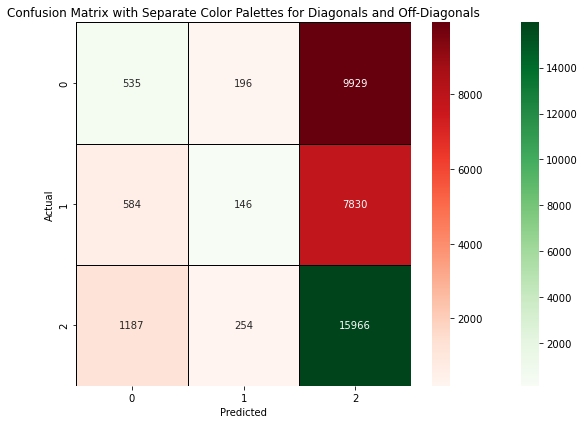

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_counts_only = df_confusion.iloc[:3, :3].astype(float)

diagonal_mask = np.eye(df_counts_only.shape[0], dtype=bool)


plt.figure(figsize=(8, 6))

# Plot the diagonal values with one color palette (correct classifications)
sns.heatmap(df_counts_only, annot=True, mask=~diagonal_mask, cmap="Greens", cbar=True, fmt='g', linewidths=1, linecolor='black')

# Plot the off-diagonal values with another color palette (misclassifications)
sns.heatmap(df_counts_only, annot=True, mask=diagonal_mask, cmap="Reds", cbar=True, fmt='g', linewidths=1, linecolor='black')


plt.title('Confusion Matrix with Separate Color Palettes for Diagonals and Off-Diagonals')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


## Misclasisfications by timestep and item type

### Some code

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# append true and predicted labels to our dataset
df['y_actual'] = pd.Series(true_labels)
df['y_predicted'] = pd.Series(predicted_labels)

# Identify misclassified instances
df_misclassified = df[df['y_actual'] != df['y_predicted']]

# Distribution of 'timestep' for misclassified instances
timestep_distribution = df_misclassified['timestep'].value_counts()
print("Timestep Distribution for Misclassified Instances:")
print(timestep_distribution)

# Define item type 
df_misclassified['item_type'] = df_misclassified[['istrack', 'isalbum', 'isartist', 'isgenre']].idxmax(axis=1)

Timestep Distribution for Misclassified Instances:
33     255
30     253
35     253
36     249
43     245
      ... 
166      3
168      3
170      2
167      2
169      1
Name: timestep, Length: 170, dtype: int64


C:\Users\howen\AppData\Local\Temp/ipykernel_15152/3523464613.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_misclassified['item_type'] = df_misclassified[['istrack', 'isalbum', 'isartist', 'isgenre']].idxmax(axis=1)


### Misclassifications vs timestep 

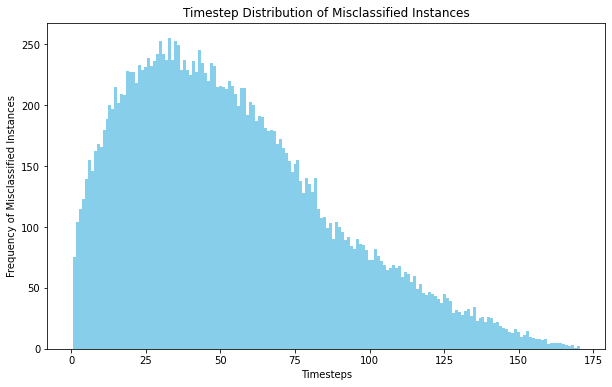

In [49]:
import matplotlib.pyplot as plt

# IMPORTANT: 'timestep_distribution' is the Pandas Series with index as timesteps and values as frequencies

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(timestep_distribution.index,
        timestep_distribution.values, width=1.0, color='skyblue')


plt.xlabel('Timesteps')
plt.ylabel('Frequency of Misclassified Instances')
plt.title('Timestep Distribution of Misclassified Instances')


plt.show()


The model seems to suffer from a "cold start" (i.e. making huge misclassifiactions early on). This will be further investigated below.

## Feature contributions (excluding itemid)

For each of the 6 features $x_k,\ k=1,..,6$, plot $x_k$ against $w_{1k} f_k(x_k),\  w_{2k} f_k(x_k),\  w_{3k} f_k(x_k)$

Hopefully can use a $3 \times 6$ plot as follows

$$
\begin{matrix}
w_{11} \ f_1(x_1) & w_{12} \ f_2(x_2) & w_{13}\ f_3(x_3) & \cdots & w_{16}\ f_6(x_6) \\
w_{21} \ f_1(x_1) & w_{22} \ f_2(x_2) & w_{23}\ f_3(x_3) & \cdots & w_{26}\ f_6(x_6) \\
w_{31} \ f_1(x_1) & w_{32} \ f_2(x_2) & w_{33}\ f_3(x_3) & \cdots & w_{36}\ f_6(x_6) \\
\end{matrix}
$$

### Some function

In [131]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_feature_output(feature_network_params, feature_values):
    """
    compute output of the entire feature-specific neural network f_k(x_k).
    
    args:
        feature_network_params (dict): dict containing the weights and biases of a single feature-specific network.
        feature_values (np.ndarray): Input feature values.
        
    return:
        np.ndarray: The output of the feature-specific network for the given feature values.
    """
    # First layer (Linear -> Activation)
    layer1_output = np.dot(feature_values.reshape(-1, 1), feature_network_params['0.weight'].T) + feature_network_params['0.bias']
    layer1_output = np.maximum(0, layer1_output)  # assuming ReLU activation here (can modify if needed)
    
    # Second layer (Linear -> Activation)
    layer2_output = np.dot(layer1_output, feature_network_params['2.weight'].T) + feature_network_params['2.bias']
    layer2_output = np.maximum(0, layer2_output)  # assuming ReLU activation here (can modify if needed)
    
    # Third layer (Linear only, final output)
    feature_output = np.dot(layer2_output, feature_network_params['5.weight'].T) + feature_network_params['5.bias']
    
    return feature_output.mean(axis=1)  # Assuming mean output over neurons

def plot_feature_contributions(model_parameters, features, num_classes=3):
    """
    Plot x_k against w_ik * f_k(x_k) for each feature k and each class i.
    
    args:
        model_parameters (dict): Loaded model parameters from the saved model.
        features (pd.DataFrame): feature values excluding item_id.
        num_classes (int): Number of classes in the classification task (default is 3).
    """
    # fully connected layer weights
    fc_weights = model_parameters['fc.weight']  # Shape: [num_classes, num_features + 1]
    
    # feature names (again, they MUYST respect the order in DataLoader/CustomDataset class)
    feature_names = ["istrack", "isalbum", "isartist", "isgenre", "timestep"]
    
    fig, axes = plt.subplots(nrows=num_classes, ncols=len(feature_names), figsize=(20, 12))
    fig.suptitle("Feature Contributions to Logits for Each Class", fontsize=27)
    
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)

    for class_idx in range(num_classes):
        for feature_idx, feature_name in enumerate(feature_names):
            
            feature_values = features[feature_name].values  # Extract feature values from the DataFrame
            ax = axes[class_idx, feature_idx]
            ax.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0
            
            if feature_name in ['istrack', 'isalbum', 'isartist', 'isgenre']:  # Binary feature
                # bar plot for binary variables
                counts = np.bincount(feature_values.astype(int))
                bars = [0, 1]
                
                # Get the contribution for the binary feature f_k(x_k)
                contributions = counts * fc_weights[class_idx][feature_idx].item()
            
 
                ax.bar(bars, contributions, label=f'Class {class_idx}', color='b', alpha=0.7)
                ax.set_title(f'{feature_name} (class {class_idx})', fontsize=25)
                ax.set_xlabel(f'$x_k$={feature_name}', fontsize=20)
                ax.set_ylabel(f'w_{class_idx} * $f_k(x_k)$', fontsize=20)
                y_lim = max(abs(contributions))
                ax.set_ylim([-y_lim, y_lim])

            else:  # Continuous feature (e.g., timestep)
                # Get the parameters of the specific feature network
                feature_network_params = {
                    '0.weight': model_parameters[f'feature_nns.{feature_idx}.network.0.weight'],
                    '0.bias': model_parameters[f'feature_nns.{feature_idx}.network.0.bias'],
                    '2.weight': model_parameters[f'feature_nns.{feature_idx}.network.2.weight'],
                    '2.bias': model_parameters[f'feature_nns.{feature_idx}.network.2.bias'],
                    '5.weight': model_parameters[f'feature_nns.{feature_idx}.network.5.weight'],
                    '5.bias': model_parameters[f'feature_nns.{feature_idx}.network.5.bias']
                }
                
                # Calculate the output of f_k(x_k) by passing feature values through the entire network
                feature_function_output = calculate_feature_output(feature_network_params, feature_values)
                
                # Calculate the contribution to the logit: w_ik * f_k(x_k)
                weight = fc_weights[class_idx][feature_idx]  # Weight for this class and feature
                contribution = weight * feature_function_output
                
                # Plot a single curve for timestep (a continuous feature)
                ax.plot(feature_values, contribution, label=f'Class {class_idx}', color='b', alpha=0.7)
                ax.set_title(f'{feature_name} (class {class_idx})', fontsize=25)
                ax.set_xlabel(f'$x_k$={feature_name}', fontsize=20)
                ax.set_ylabel(f'w_{class_idx} * $f_k(x_k)$', fontsize=20)
                y_lim = max(abs(contribution))
                ax.set_ylim([-y_lim, y_lim])
                
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.savefig('feature_importance_no_itemid_plt.png', facecolor='white', transparent=False)
    
    plt.show()
    




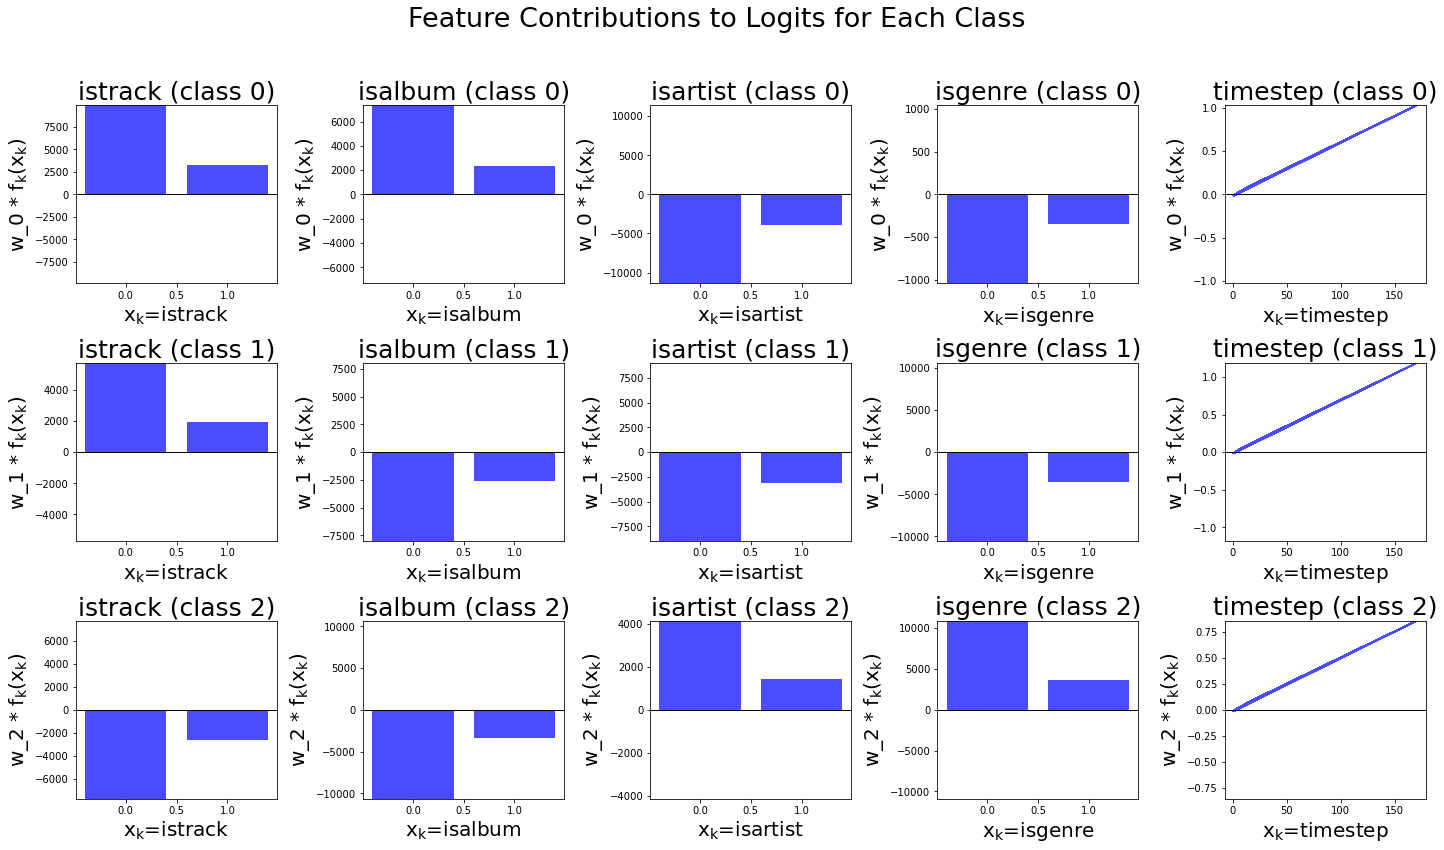

In [132]:
# NOTE order of columns has to respect the order in which they are passed in the customDataset class!!
plot_feature_contributions(model_parameters, df.loc[:,["istrack", "isalbum", "isartist", "isgenre","timestep"]], num_classes=3)



The NAM apparently says that user interactions on album, artist, and genres substantially decrease the odds of a user giving extreme ratings (either class 0 or class 2). However, medium ratings could still be associated with diverse user interactions, not just tracks exclusively (the distribution of item types across user interactions that give medium ratings is relatively uniform). 

I.e. user interactions with albums, artists, and genres tend to influence extreme ratings (rating class 0 or 2). 


Interestingly, the contribution of the timestep feature is deemed to be linear across all classes with slightly steeper slopes for class 0 and class 1, implying that overtime, users are slightly less likely to give extremely high ratings). However, while this suggests that the timing of ratings has positive infleunce overtime, this relationship is clearly too simplistic (i.e. temporal aspects are being modelled too simplistifcally).

**GO FURTHER: Connection between earlier timestamps being classified as class 2 and misclassifications concentrating around earlier timestamps**
- Further analysis shows that earlier ratings are deemed to be correlated with extreme ratings (extremely high or extremely small, 2 or 0) with ratings later in time deemed to be correlated with moderate ratings.


Although NAM is able to model local features very flexibily (since we have feature specific neural networks), it only adds those contribuitions without considering any feature interactions. This means that adding complexities locally within each feature is not sufficient to explain the ratings.



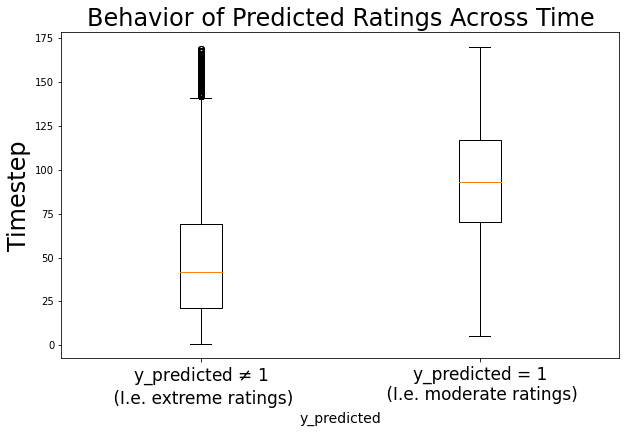

In [128]:
# Create the plot
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.figure(figsize=(10, 6))

# Prepare the data for boxplots
data = [df[df["y_predicted"] != 1]["timestep"], df[df["y_predicted"] == 1]["timestep"]]



plt.boxplot(data, labels=['y_predicted $\\ne$ 1\n (I.e. extreme ratings)', 'y_predicted = 1\n (I.e. moderate ratings)'])


plt.xlabel('y_predicted', fontsize=14)
plt.ylabel('Timestep', fontsize=24)
plt.title('Behavior of Predicted Ratings Across Time', fontsize=24)
plt.xticks(fontsize=17)

plt.savefig('behavior_pred_ratings_across_time_plt.png', facecolor='white', transparent=False)


plt.show()


# Model performance for nested 20-fold cross validation

## Error bars for acc precision recall

In [ ]:
with open("cv_results.json", "r") as f:
    cv_results = json.load(f)
len(cv_results) # 20 
type(cv_results[0]) # each is a dictionary of predictions on outer test data. 

In [ ]:
means=[]
for IDX in range(20):
    mean= np.mean(
        np.array(cv_results[IDX]["val_preds"]) == np.array(cv_results[IDX]["val_labels"])
    )
    print(mean)
    means.append(mean)
means = np.array(means)
print(f"Mean accuracy: {np.mean(means)}")
    


In [ ]:
(type(cv_results), type(cv_results[0]), cv_results[0].keys())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.metrics import accuracy_score, precision_score, recall_score

# initialize lists to store accuracy, precision, and recall for each fold
all_accuracies=[]
all_precisions_macro =[]
all_recalls_macro=[]

# nfolds 
n_folds=len(cv_results)

# 95% conf level. 
t_value = t.ppf((1 + 0.95) / 2, df=n_folds - 1)  # t-statistic for 95% CI and n-1 degrees of freedom

for fold_result in cv_results:
    val_labels=fold_result['val_labels']  # True labels for the fold
    val_preds=fold_result['val_preds']    # Predicted labels for the fold
    
    # calculate accuracy, precision, and recall for this fold
    accuracy=accuracy_score(val_labels, val_preds)
    precision_macro=precision_score(val_labels, val_preds, average='macro')
    recall_macro=recall_score(val_labels, val_preds, average='macro')
    
    # append results to lists
    all_accuracies.append(accuracy)
    all_precisions_macro.append(precision_macro)
    all_recalls_macro.append(recall_macro)

# calculate mean and standard deviation for each metric
mean_accuracy=np.mean(all_accuracies)
std_accuracy=np.std(all_accuracies, ddof=1)

mean_precision_macro=np.mean(all_precisions_macro)
std_precision_macro=np.std(all_precisions_macro, ddof=1)

mean_recall_macro=np.mean(all_recalls_macro)
std_recall_macro=np.std(all_recalls_macro, ddof=1)

# compute the error bars (t-dist)
error_bar_accuracy = t_value*(std_accuracy / np.sqrt(n_folds))
error_bar_precision = t_value*(std_precision_macro / np.sqrt(n_folds))
error_bar_recall = t_value*(std_recall_macro / np.sqrt(n_folds))

# plot the results with error bars
metrics=['Accuracy', 'Precision (Macro)', 'Recall (Macro)']
means=[mean_accuracy, mean_precision_macro, mean_recall_macro]
error_bars=[error_bar_accuracy, error_bar_precision, error_bar_recall]

# create the plot with smaller bars and larger error bars
plt.figure(figsize=(8, 5))

# adjusting the width of the bars and capsize for larger error bars
bars=plt.bar(metrics, means, yerr=error_bars, capsize=10, width=0.3, color=['lightgrey', 'lightgrey', 'lightgrey'], alpha=0.7)

# annotate the bars with mean estimates, moving the text slightly to the right
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width() / 2 + 0.07, bar.get_height() - 0.015, f'{mean:.3f}', ha='left', va='bottom', fontsize=12)

plt.ylabel('Estimates')
plt.title('Average Accuracy, (Macro) Precision, and (Macro) Recall with Error Bars')


plt.tight_layout()
plt.show()





In [ ]:
1-mean_accuracy, std_accuracy**2 

In [ ]:
mean_precision_macro, std_precision_macro**2  

In [ ]:
mean_recall_macro, std_recall_macro**2  

## one-vs-all ROC curve

In [60]:
df

,Unnamed: 0,user_id,item_id,ratings,istrack,isalbum,isartist,isgenre,ratings_discretized,timestep,y_actual,y_predicted
0,0,716610,36870,80,0,0,0,1,2,1,2,0
1,1,716610,88858,80,0,0,0,1,2,2,2,0
2,2,716610,111280,80,0,0,0,1,2,3,2,0
3,3,716610,123601,80,0,0,0,1,2,4,2,0
4,4,716610,144592,80,0,0,0,1,2,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36622,36622,820331,185040,30,1,0,0,0,1,153,1,2
36623,36623,820331,383051,30,0,1,0,0,1,154,1,2
36624,36624,820331,478832,30,0,0,1,0,1,155,1,2
36625,36625,820331,53658,70,0,1,0,0,2,156,2,2


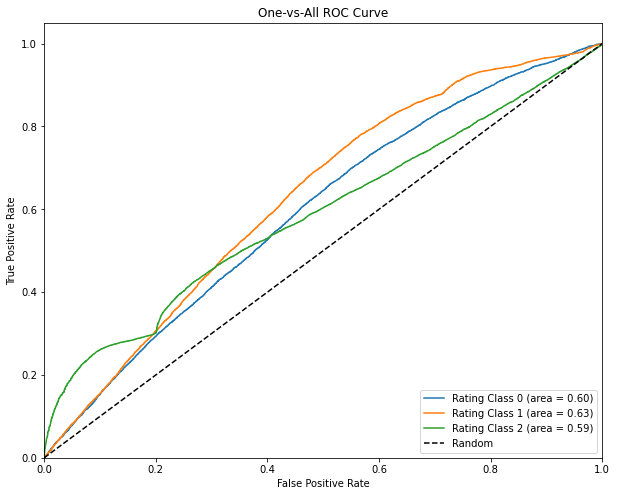

In [73]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def load_model_from_parameters(model, model_parameters):
    
    
    """
    Given a specified torch.nn model "model" (with hyperparameters specified), we
    load the estimated saved model parameters from the entire data into
    the model. Also the weights were originally numpy arrays, so need to be
    converted to a tensor. 
    
    
    """
    for param_name, param in model.named_parameters():
        if param_name in model_parameters:
            param.data = torch.tensor(model_parameters[param_name],
                                      dtype=torch.float32)


def compute_softmax_probs(model, train_loader, model_parameters):
    
    """
    calculate the logits and the softmax probabilities
    for all training samples.
    """
    
    model.eval()  # Set the model to evaluation mode
    load_model_from_parameters(model,
                               model_parameters)  # load saved trained params into model
    
    softmax_probs = []
    true_labels = []
    
    # Forward pass through the model for all data in train_loader
    with torch.no_grad(): #again, ensueer that it doesnt calcualte gradients.
        for item_ids, features, labels in train_loader:
            #print(item_ids.to(device))
            item_ids, features=item_ids.to(device), features.to(device)
            logits=model(features, item_ids)  # forward pass
            probs=F.softmax(logits, dim=1)  # softmax probabilities
            softmax_probs.append(probs.cpu().numpy())  # move to CPU + store
            true_labels.extend(labels.cpu().numpy())  # store the true labels
    
    return np.vstack(softmax_probs), np.array(true_labels)


def plot_one_vs_all_roc_curve(softmax_probs, true_labels, num_classes):
    """
    plot  one-vs-all ROC curve for each class.
    """
    plt.figure(figsize=(10, 8))
    
    for i in range(num_classes):
        
        # Binarize class i VS class ~i
        binary_true_labels=(true_labels == i).astype(int)
        
        # get predicted probs for class i: p.hat(i) [resp. class ~i as the "negative" class w predicted prob 1 - p.hat(i)]
        class_probs =softmax_probs[:, i]
        
        # Compute ROC curve and ROC area (tpr: recall for positive class, fpr: 1-recall for neg. class)
        fpr, tpr, _= roc_curve(binary_true_labels, class_probs)
        roc_auc=auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr,
                 label=f'Rating Class {i} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-All ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# note that we saved the best hyperparameters
# in best_params variable. 

model = NAMWithEmbeddings(
    num_inputs=5,
    num_units=best_params["num_units"], 
    hidden_sizes=best_params["hidden_sizes"], 
    dropout=best_params["dropout"],
    feature_dropout=best_params["feature_dropout"],
    embedding_size=127,
    num_item_ids=df['item_id'].nunique(),
    num_classes=3,  
    activation=best_params["activation"]
)


#get training and data in batches
train_loader_allData =DataLoader(CustomDataset(df),
                                 batch_size=256,
                                 shuffle=False)


softmax_probs, true_labels = compute_softmax_probs(model, train_loader_allData, model_parameters)

# Plot the One-vs-All ROC curve
plot_one_vs_all_roc_curve(softmax_probs, true_labels, num_classes=3)
